state.info_loss# Walkthrough - RBIG

In [1]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint
# from rbig_jax.rbig import RBIG
# from rbig_jax.data import get_classic
# from rbig_jax.information.rbig import rbig_init
# from rbig_jax.information.reduction import information_reduction
# from rbig_jax.information.entropy import histogram_entropy
# from rbig_jax.plots.info import plot_total_corr
# from rbig_jax.plots.joint import plot_joint
# from rbig_jax.plots.prob import plot_joint_prob
# from rbig_jax.transforms.gaussian import init_params

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

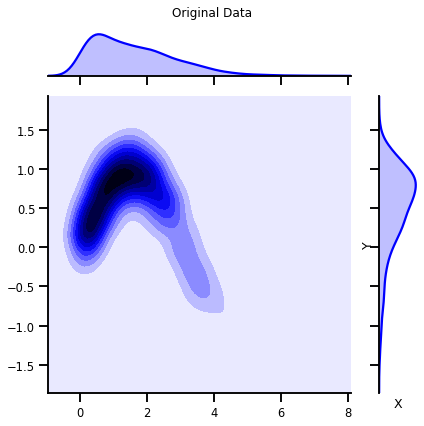

In [2]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

## Training

So now we have our step function and we need some kinda of condition. We will do 3 conditions:

1. We need a maximum number of layers
2. We need a minimum number of layers
3. We need no changes between a running loss

In [3]:
# Params
method= "histogram"
support_ext= 10
precision= 1_000
alpha= 1e-5
min_layers= 10
max_layers= 100
tol_layers= 50
threshold= 0.25

In [4]:
from rbig_jax.information.rbig import rbig_init
from rbig_jax.information.total_corr import information_reduction
from collections import namedtuple

# initialize state
TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "X",
    ]
)

# init RBIG params getter
rbig_params_init = rbig_init(
    method=method, support_ext=support_ext, precision=precision, alpha=alpha,
)

# # compile function (faster)
# rbig_params_init = jax.jit(rbig_params_init)
# _ = rbig_params_init(data[:10])

# init loss with stopping criteria
init_loss = np.pad(np.zeros((max_layers,)), (tol_layers, 0))
init_loss = jax.ops.index_update(
    init_loss, np.arange(0, tol_layers, dtype=int), 1.0
)
# print(init_loss)
train_state = TrainState(n_layers=0, info_loss=init_loss, X=data)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
import jax.numpy as jnp

def condition(state):

    # get relevant layers (moving window)
    layers = state.info_loss[state.n_layers : tol_layers + state.n_layers]
#     print(layers)
    info_sum = np.sum(np.abs(layers))

    # condition - there needs to be some loss of info
    info_crit = info_sum == 0.0
    verdict = jax.lax.bitwise_not(info_crit)
#     print(f"Info: {info_sum}, verdict: {verdict}")
    return verdict


def body(train_state):
    Xtrans = rbig_params_init(train_state.X)

    # calculate the information loss
    it = information_reduction(train_state.X, Xtrans)
    
    return TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=jax.ops.index_update(train_state.info_loss, tol_layers + train_state.n_layers, it),
        X=Xtrans,
    )

In [6]:
%%time

while condition(train_state):
    train_state = body(train_state)

CPU times: user 54.3 s, sys: 4min 57s, total: 5min 52s
Wall time: 37.2 s


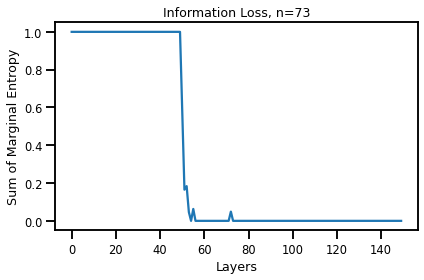

In [7]:
plot_info_loss(train_state.info_loss, n_layers=train_state.n_layers)

### Speed

In [8]:
%%time
# print(init_loss)
train_state = TrainState(n_layers=0, info_loss=init_loss, X=data)
# 
body_jitted = jax.jit(body)
# _ = body_jitted(train_state)

CPU times: user 16 µs, sys: 78 µs, total: 94 µs
Wall time: 101 µs


In [9]:
%%time

while condition(train_state):
    train_state = body_jitted(train_state)

CPU times: user 19.9 s, sys: 1min 8s, total: 1min 27s
Wall time: 16.1 s


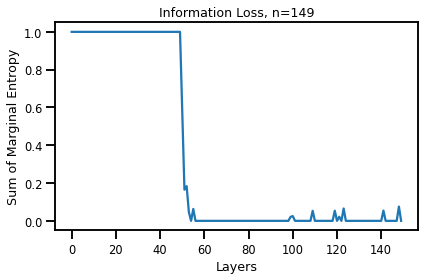

In [10]:
plot_info_loss(train_state.info_loss, n_layers=train_state.n_layers)

In [11]:
train_state.info_loss

DeviceArray([1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             0.58918961, 0.16489241, 0.1837185 , 0.04619229, 0.        ,
             0.06285402, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.

In [12]:
state

NameError: name 'state' is not defined

### RBIG 4 IT


In [15]:
from rbig_jax.information.total_corr import rbig_total_corr

In [16]:
%%time

data = get_classic(10_000)

state = rbig_total_corr(data, threshold=0.25)

CPU times: user 51.3 s, sys: 3.39 s, total: 54.7 s
Wall time: 26 s


In [17]:
print(f"Mutual Info: {state.total_corr:.4f}")
print(f"Entropy: {state.entropy:.4f}")

Mutual Info: 0.7170
Entropy: 2.3646


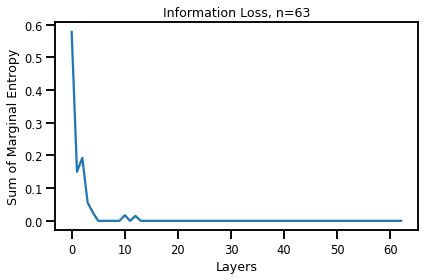

In [18]:
plot_info_loss(state.info_loss, n_layers=state.n_layers)

<Figure size 432x288 with 0 Axes>

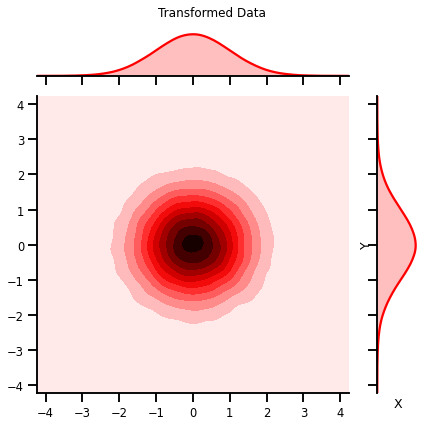

In [19]:
plot_joint(state.data, "red", "Transformed Data", kind='kde', logger=False)

### Total Correlation

#### Sample Data

In [21]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

#### Original 

In [22]:
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 9.9326


#### RBIG

In [23]:
%%time

state = rbig_total_corr(data, threshold=0.25)

print(f'Total Correlation: {state.total_corr:.4f}')

Total Correlation: 9.8999
CPU times: user 39.5 s, sys: 53.8 s, total: 1min 33s
Wall time: 36.6 s


### Entropy

#### Sample Data

In [24]:
#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

#### True Entropy

In [25]:
from rbig_jax.information.entropy import histogram_entropy

Hx = jax.vmap(histogram_entropy, in_axes=(0, None))(data.T, 2)

print(f"Hx: {Hx.sum():.4f}")

H_original = Hx.sum() + np.log2(np.abs(np.linalg.det(A)))

# H_original *= np.log(2)

print(f"H: {H_original:.4f}")

Hx: 28.7639
H: 22.7575


### RBIG

In [26]:
%%time
state = rbig_total_corr(data, threshold=0.25)

print(f'Entropy: {state.entropy:.4f}')

Entropy: 18.8640
CPU times: user 36.6 s, sys: 1min 4s, total: 1min 40s
Wall time: 32.3 s


### Mutual Information

In [27]:
#Parameters
n_samples = 10000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random Data
A = rng.rand(2 * d_dimensions, 2 * d_dimensions)

# Covariance Matrix
C = A @ A.T
mu = np.zeros((2 * d_dimensions))

dat_all = rng.multivariate_normal(mu, C, n_samples)

CX = C[:d_dimensions, :d_dimensions]
CY = C[d_dimensions:, d_dimensions:]

X = dat_all[:, :d_dimensions]
Y = dat_all[:, d_dimensions:]

#### Real Mutual Information

In [28]:
H_X = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CX)))
H_Y = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CY)))
H = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(C)))

mi_original = H_X + H_Y - H
mi_original *= np.log(2)

print(f"MI: {mi_original:.4f}")

MI: 8.0713


#### RBIG

In [29]:
from rbig_jax.information.mi import rbig_mutual_info

In [30]:
%%time
state = rbig_mutual_info(np.array(X), np.array(Y), fit_forward_func_jitted)

NameError: name 'fit_forward_func_jitted' is not defined

In [31]:
print(f"Mutual Info, MI(X,Y): {state.mutual_info:.4f}")
print(f"Mutual Info, MI(X): {state.MIx:.4f}")
print(f"Mutual Info, MI(Y): {state.MIy:.4f}")

AttributeError: 'RBIGEntropy' object has no attribute 'mutual_info'